In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/product_data.csv')

In [ ]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [ ]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
df = df[df['store'] == 1]
df = df[df['item'] == 1]

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression

df['weekday'] = df['date'].dt.weekday
df['weekend'] = df['date'].dt.weekday >=6
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)
df['weekend'] = np.where(df.weekend == 0, 2, df.weekend)


# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)                         
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

train_df.head(20)

,date,store,item,sales,year,month,day,weekday,weekend
0,2013-01-01,1,1,13,2013,1,1,1,2
1,2013-01-02,1,1,11,2013,1,2,2,2
2,2013-01-03,1,1,14,2013,1,3,3,2
3,2013-01-04,1,1,13,2013,1,4,4,2
4,2013-01-05,1,1,10,2013,1,5,5,2
5,2013-01-06,1,1,12,2013,1,6,6,1
6,2013-01-07,1,1,10,2013,1,7,7,2
7,2013-01-08,1,1,9,2013,1,8,1,2
8,2013-01-09,1,1,12,2013,1,9,2,2
9,2013-01-10,1,1,9,2013,1,10,3,2


In [ ]:
ts_decomp_df = train_df.set_index('date') # set date as index
ts_decomp_df['sales'] = ts_decomp_df['sales'].astype(float)
ts_decomp_df.head()

,store,item,sales,year,month,day,weekday,weekend
date,,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1,2
2013-01-02,1,1,11.0,2013,1,2,2,2
2013-01-03,1,1,14.0,2013,1,3,3,2
2013-01-04,1,1,13.0,2013,1,4,4,2
2013-01-05,1,1,10.0,2013,1,5,5,2


<Figure size 432x288 with 0 Axes>

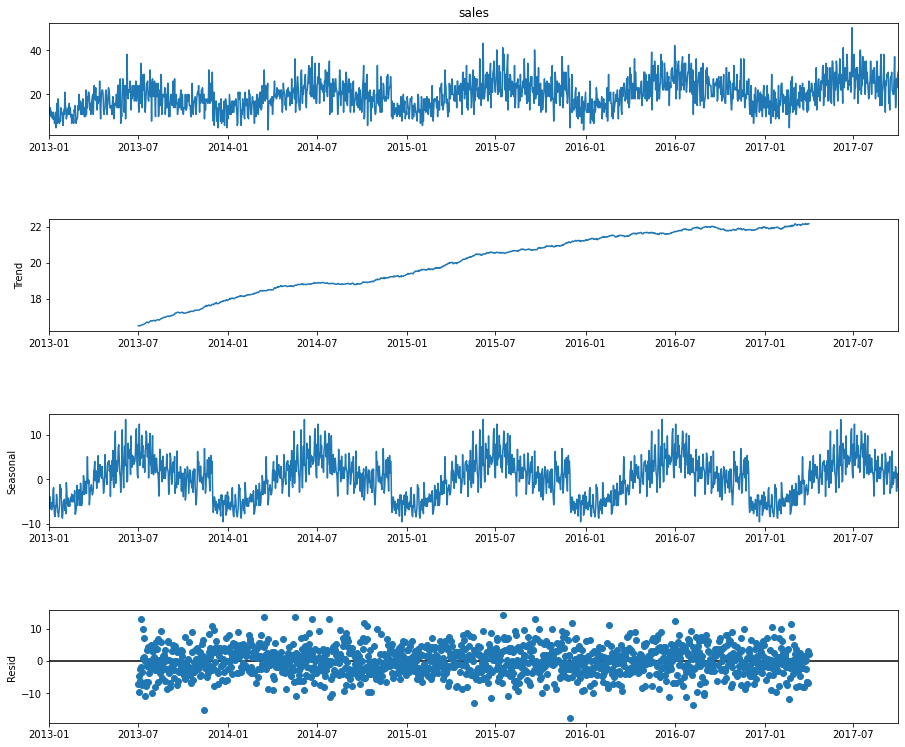

In [ ]:
result = seasonal_decompose(ts_decomp_df['sales'], model='additive', freq=365)
fig = plt.figure()  
fig = result.plot()  

fig.set_size_inches(14, 12)

**DATA EXPLORATION**
Below plots helps to understand the trends and distribution of sales through
weeks, months and years

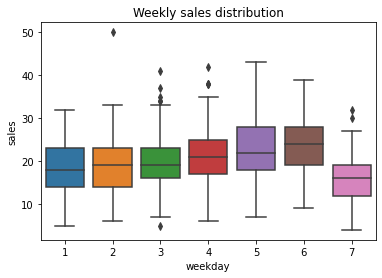

In [ ]:
plot = sn.boxplot(x='weekday', y='sales', data=df)
_ = plot.set(title='Weekly sales distribution')

From the above plot, its visible that the number of sales increases over the week reaches maximum on saturday(6) and falls down on sunday(7)

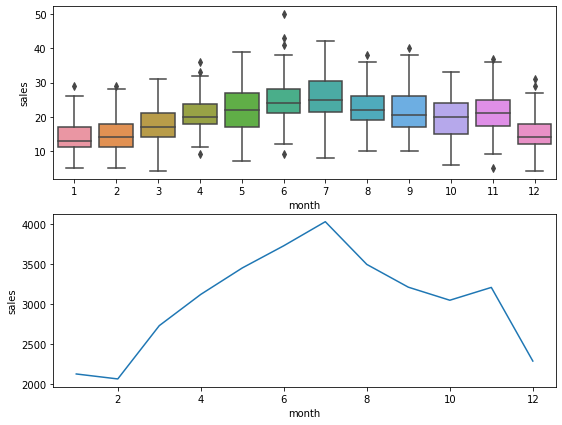

In [ ]:
monthly_agg = df.groupby('month')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])

<b>Inference:</b>  The number of sales increases in the first half of the year starting February (2), peaks in July (7), and then gradually descends, before slightly increasing in November (11) and then dropping again in December (12).

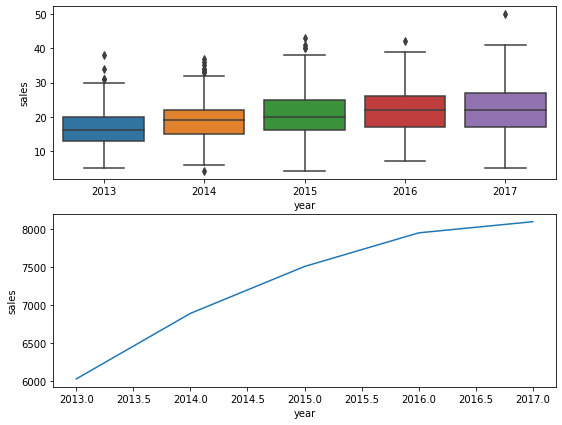

In [ ]:
yearly_agg = df.groupby('year')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='year', y='sales', data=yearly_agg, ax=axs[1])

<b>Inference:</b>  From the number of sales Vs year plot, we can infer an increasing trend over the years. The aggregate number of sales has increased from approximately 6000 in 2013 to slightly over 8000 in 2017, i.e. a <b>33.3% increase in the number of sales</b> approximately. A clear trend is captured by the lineplot above. 

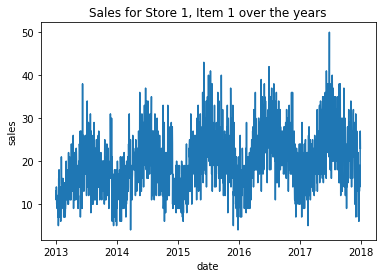

In [ ]:
plot = sn.lineplot(x='date', y='sales', data=df)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')

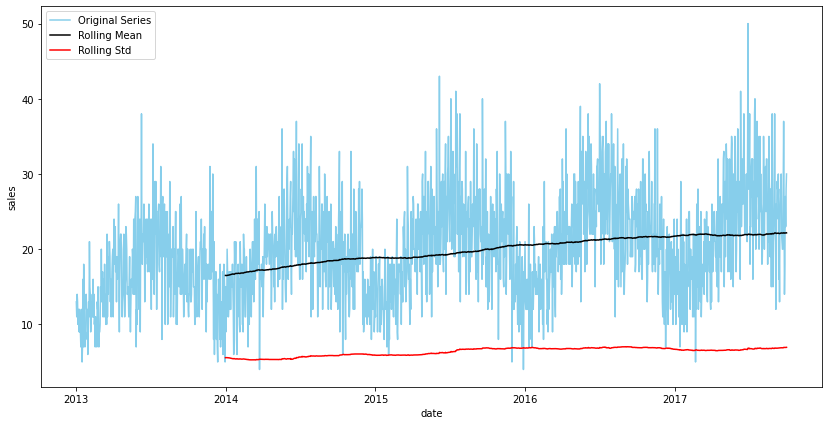

Test statistic = -2.937
P-value = 0.041
Critical values :
	1%: -3.434179908502461 - The data is not stationary with 99% confidence
	5%: -2.863231689892687 - The data is  stationary with 95% confidence
	10%: -2.567670609760268 - The data is  stationary with 90% confidence


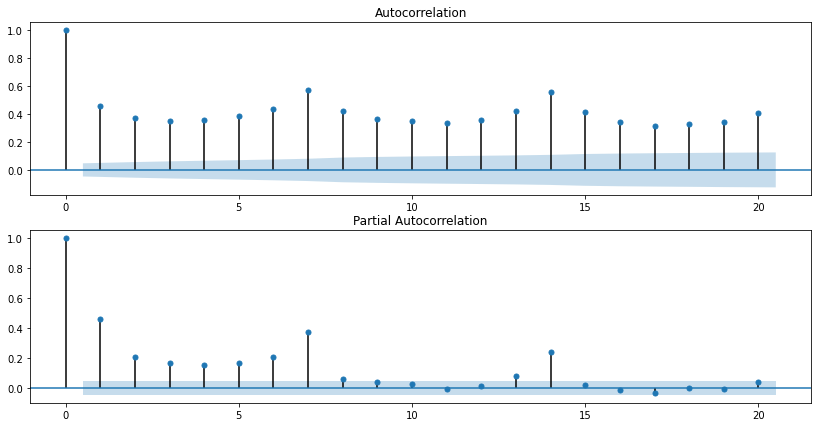

In [ ]:
arima_df = train_df[['date', 'sales']].set_index('date')
arima_test_df = test_df[['date', 'sales']].set_index('date')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean = timeseries.rolling(window=365).mean()
    rollstd = timeseries.rolling(window=365).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()
    
    # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")
    
    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))
        
    # Autocorrelation Plots
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)
    
test_stationarity(arima_df.sales)

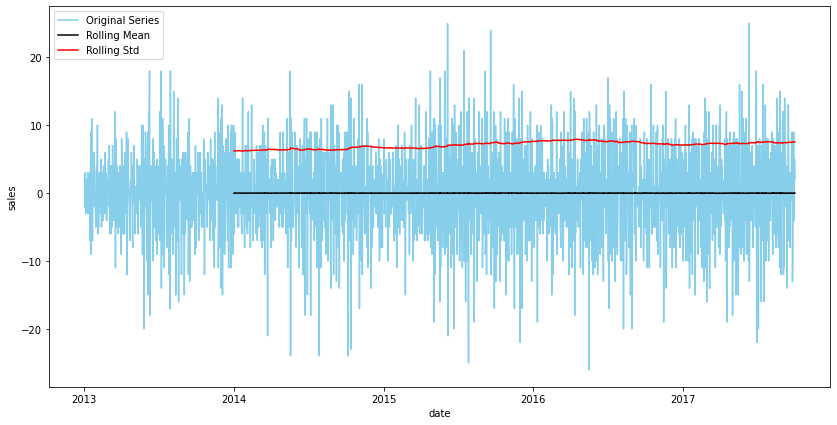

Test statistic = -12.326
P-value = 0.000
Critical values :
	1%: -3.434179908502461 - The data is  stationary with 99% confidence
	5%: -2.863231689892687 - The data is  stationary with 95% confidence
	10%: -2.567670609760268 - The data is  stationary with 90% confidence


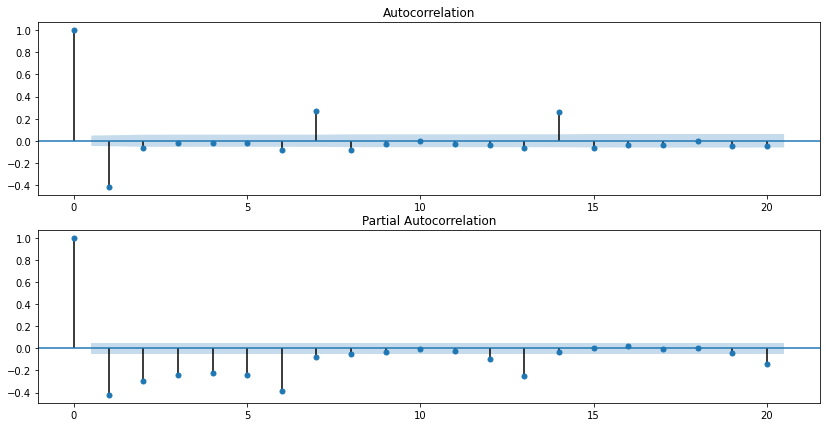

In [ ]:
first_difference = arima_df.sales - arima_df.sales.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))
# Check for stationarity after differencing
test_stationarity(first_difference.sales)

In [ ]:
arima_model61 = ARIMA(arima_df.sales, (6,1,1)).fit(disp=False)
print(arima_model61.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1733
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -5306.599
Method:                       css-mle   S.D. of innovations              5.168
Date:                Thu, 01 Dec 2022   AIC                          10631.197
Time:                        12:21:42   BIC                          10680.316
Sample:                    01-02-2013   HQIC                         10649.364
                         - 09-30-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0072      0.023      0.314      0.754      -0.038       0.052
ar.L1.D.sales    -0.6038      0.063     -9.658      0.000      -0.726      -0.481
ar.L2.D.sales    -0.6031      0.050    -

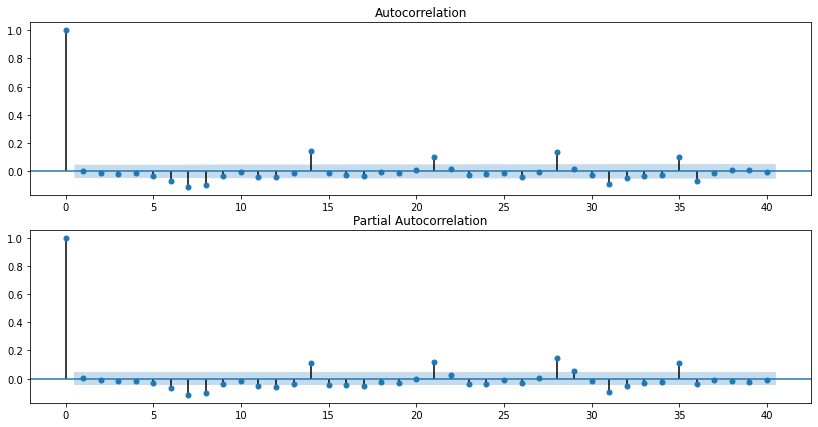

In [ ]:
residuals = arima_model61.resid
# Checking for seasonality
fig, ax = plt.subplots(2, figsize=(14,7))
ax[0] = plot_acf(residuals, ax=ax[0], lags=40)
ax[1] = plot_pacf(residuals, ax=ax[1], lags=40)

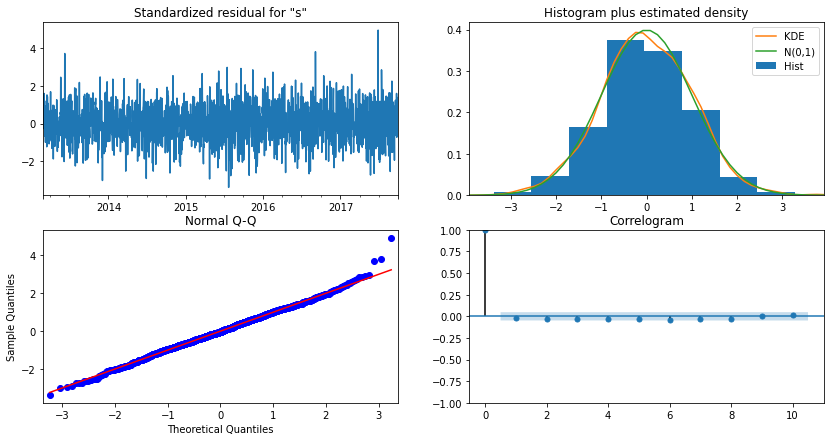

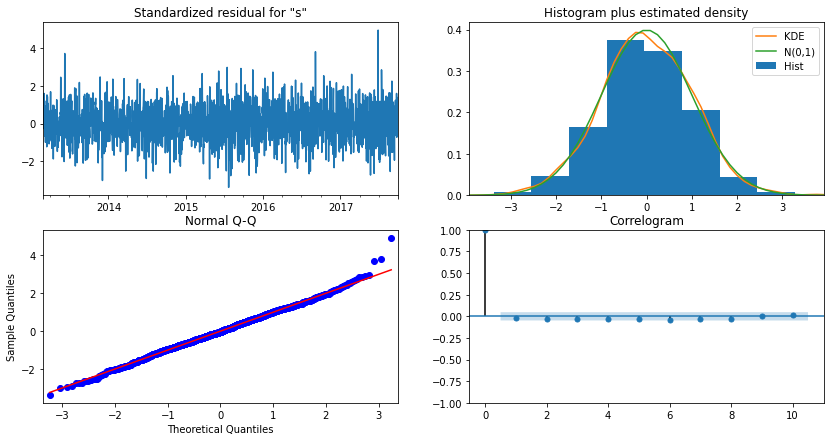

In [ ]:
# fit the model
sarima_model = SARIMAX(arima_df.sales, order=(6, 1, 0), seasonal_order=(6, 1, 0, 7), 
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
arima_test_df['pred_sales'] = sarima_fit.predict(start=arima_test_df.index[0],
                                                 end=arima_test_df.index[-1], dynamic= True)
plot = sarima_fit.plot_diagnostics(figsize=(14,7))
plot

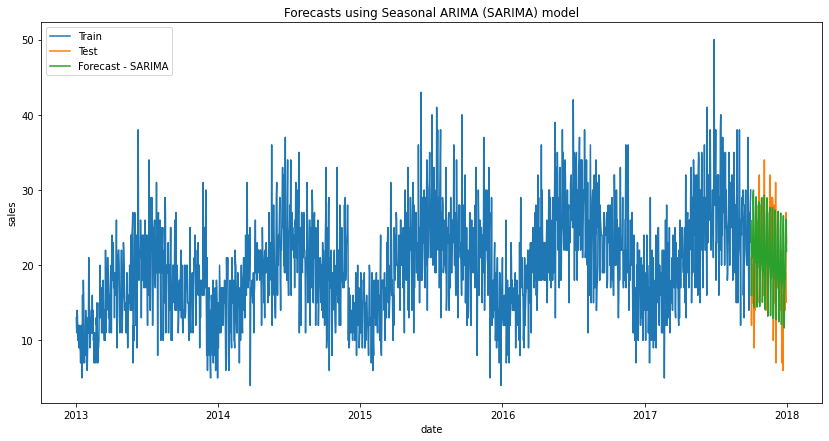

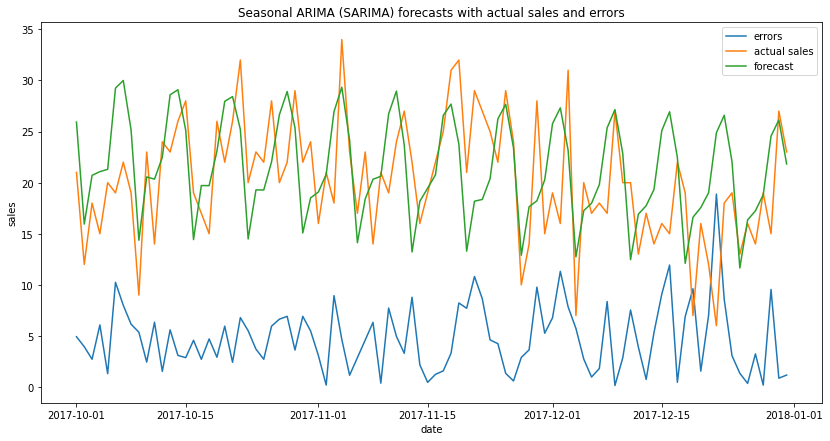

In [ ]:
# eval
arima_test_df['errors'] = arima_test_df.sales - arima_test_df.pred_sales
arima_test_df.insert(0, 'model', 'SARIMA')

# Evaluate the predictions for Seasonal ARIMA model
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='Test')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Seasonal ARIMA (SARIMA) model')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(arima_test_df.index, np.abs(arima_test_df['errors']), label='errors')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='actual sales')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal ARIMA (SARIMA) forecasts with actual sales and errors')
plt.show()





In [ ]:


def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=arima_test_df['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100


result_df_sarima = arima_test_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          SARIMA_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))

result_df_sarima


,total_sales,total_pred_sales,SARIMA_overall_error,MAE,RMSE,MAPE
model,,,,,,
SARIMA,1861,1973.19747,-112.19747,4.799933,5.839147,23.728847


In [ ]:
from sklearn.metrics import r2_score
r2_arima= r2_score( arima_test_df.sales , arima_test_df.pred_sales)
print("R squared score for SARIMA Model is : " , r2_arima)

R squared score for SARIMA Model is :  -0.005317664323632565


### 4. Supervised Machine Learning: Linear Regression
ApplyingLinear Regression to our time series data in order to forecasts sales.

In [ ]:
L_reg_df = df
L_reg_df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


####  Feature Engineering

In [ ]:
# Lag features
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    L_reg_df[lag_i] = L_reg_df.sales.shift(i)
    
# Rolling window
L_reg_df['rolling_mean'] =L_reg_df.sales.rolling(window=7).mean()
L_reg_df['rolling_max'] = L_reg_df.sales.rolling(window=7).max()
L_reg_df['rolling_min'] = L_reg_df.sales.rolling(window=7).min()

reg_df = L_reg_df.dropna(how='any', inplace=False)
reg_df = L_reg_df.drop(['store', 'item'], axis=1)

# Split the series to predict the last 3 months of 2017
L_reg_df = L_reg_df.set_index('date')
reg_train_df = L_reg_df.loc[:'2017-09-30']                        
reg_test_df = L_reg_df.loc['2017-10-01':]

#### Feature Selection and Model Building

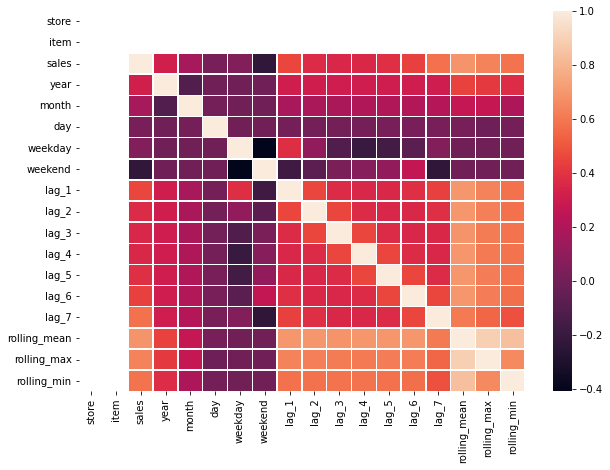

In [ ]:
# Correlation matrix with heatmap
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
_ = sn.heatmap(corr, linewidths=.5)

In [ ]:
X_train = reg_train_df.drop(['sales'], axis=1)
y_train = reg_train_df['sales'].values

X_test = reg_test_df.drop(['sales'], axis=1)
y_test = reg_test_df['sales'].values

#Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train,allow_nan, msg_dtype)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # naming the dataframe columns
print(feature_scores.nlargest(5,'Score'))  # print 5 best features

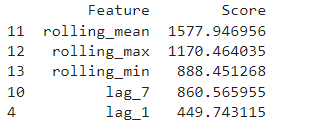

In [ ]:
# Checking for a linear relationship of the top features with sales (target variable)
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_train_df.rolling_mean, reg_train_df.sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sn.scatterplot(reg_train_df.rolling_max, reg_train_df.sales, ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_train_df.rolling_min, reg_train_df.sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sn.scatterplot(reg_train_df.lag_7, reg_train_df.sales, ax=axs[1])
_ = axs[1].set(title='Linear relationship between sales and lag_7 of sales')

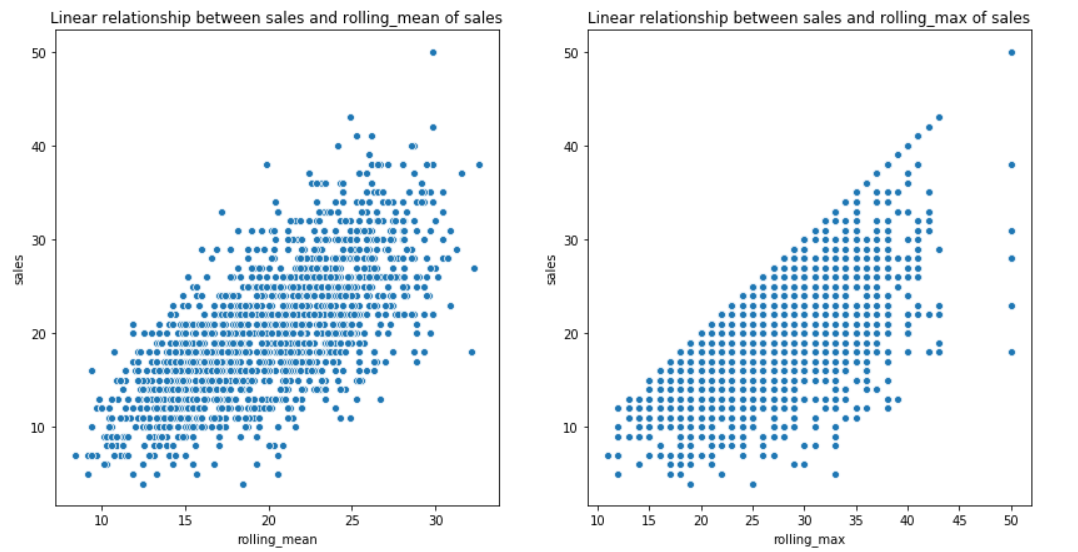

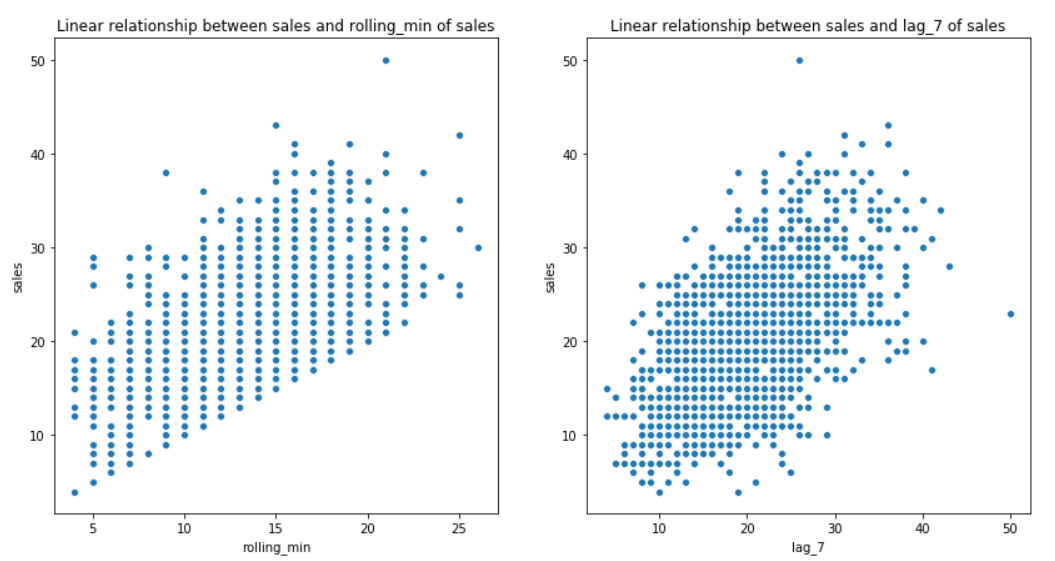

In [ ]:
# update X_train, X_test to include top features
X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

errors_df = reg_test_df[['sales']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')


Model Evaluation and Predictions

In [ ]:
# eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.sales, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

result_df_lr = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr


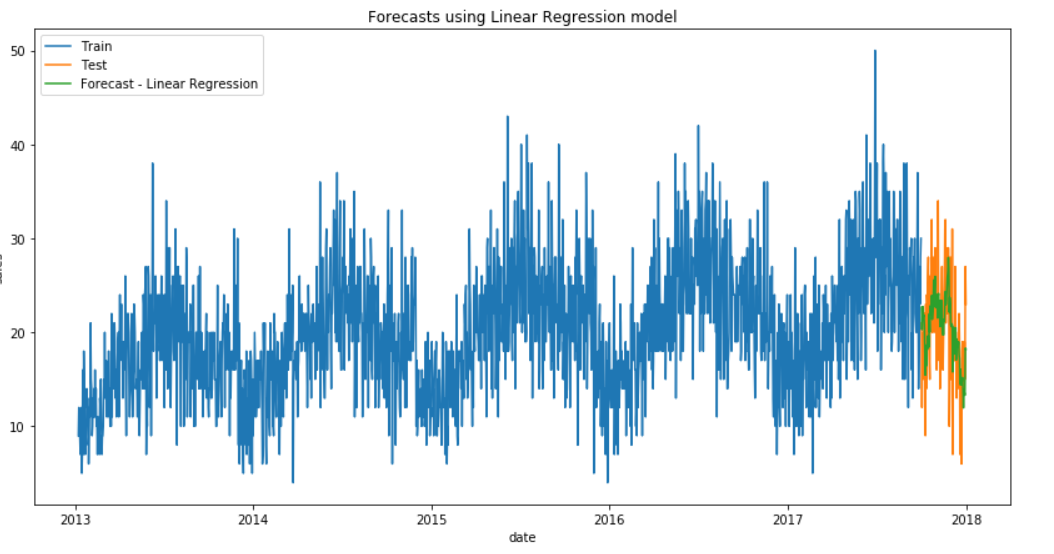

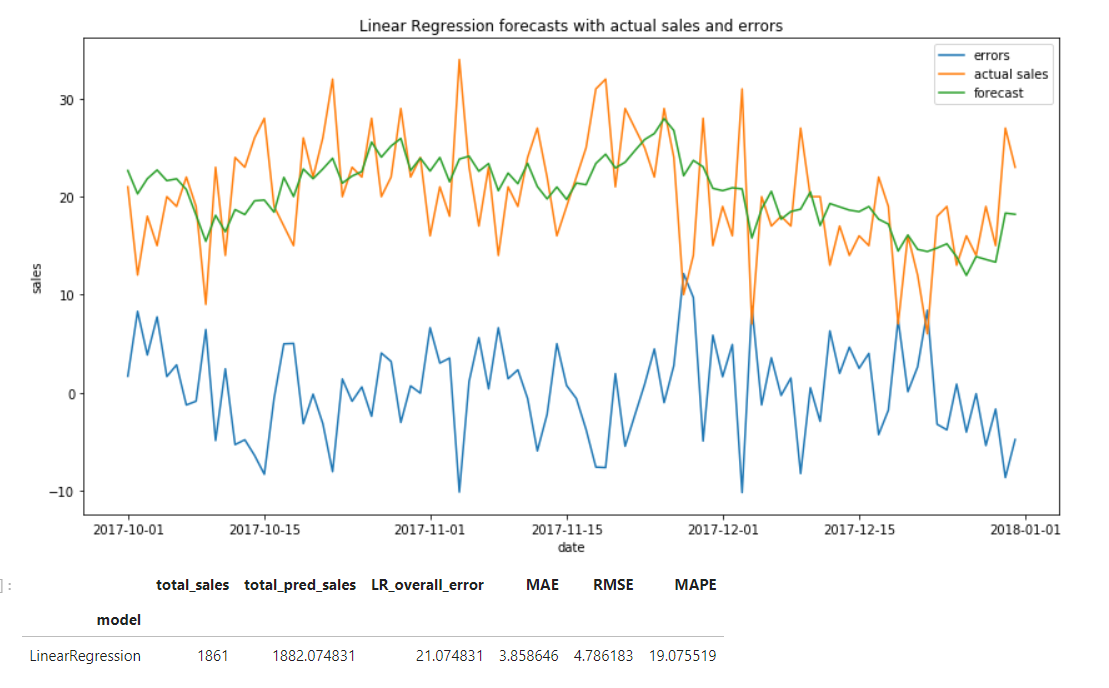

# Conclusion
"In this Research, Initially considered SARIMA as well as a linear regression model for time series forecasting. From our results we saw that the linear regression model outperformed the other model. Therefore, for this dataset we could use a regression model, rather than a time-series model to forecast sales. The main assumptions of regression models is that the patterns in the historical data will be repeated in the future, and since our data was highly seasonal and had a linear trend, it made sense why the linear regression model out-performed the other model.For further experiment Random forest , XGBoost and LSTM models are also implemented."